# A Short Introduction to Time Series Forecasting

**Forecasting** is where we try to predict an variables future value. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. In this guide you'll learn to:

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

Written with the help of [this kaggle tutorial](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series) and these [videos](https://www.youtube.com/watch?v=9QtL7m3YS9I), and some figures taken from [this blog](https://medium.com/analytics-vidhya/time-series-forecasting-c73dec0b7533).

> “Forecasting is the art of saying what will happen, and then explaining why it didn’t!”
>

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')



In [22]:
data_path = Path('price/INTC.csv') # Update your path here

In [23]:
df = pd.read_csv(data_path, header=0)

In [24]:
df = df[['Date','Open']]

In [25]:
start_date = '2013-01-01'
end_date = '2016-12-30'
df = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

### EDA

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 81 to 1088
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1008 non-null   object 
 1   Open    1008 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.6+ KB


In [27]:
df.head()

,Date,Open
81,2013-01-02,21.150000
82,2013-01-03,21.400000
83,2013-01-04,21.360001
84,2013-01-07,21.280001
85,2013-01-08,21.230000


### Data Cleaning

Steps undertaken:
- set index
- typecast

In [28]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

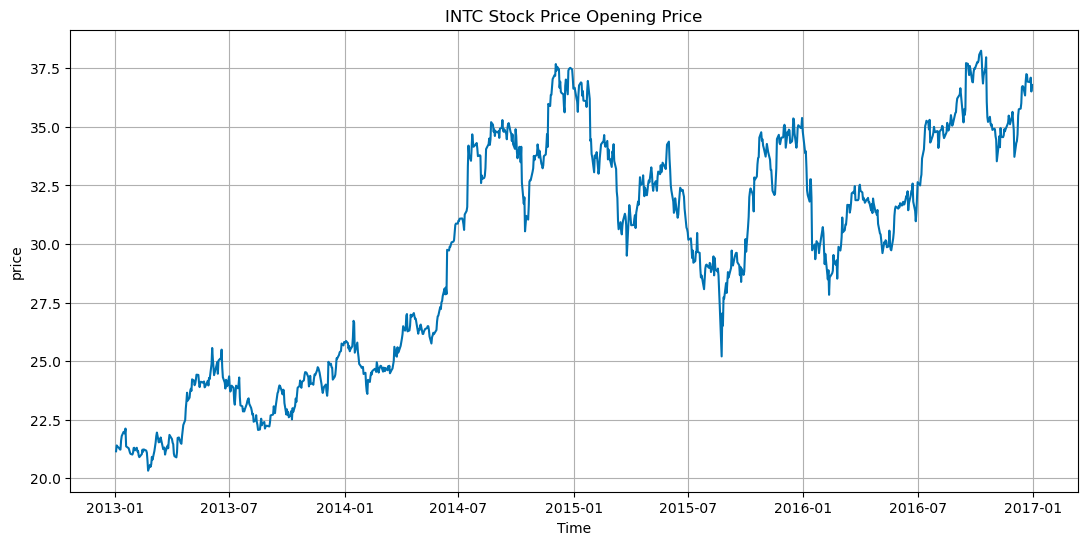

In [29]:


# Plot data
plt.figure(figsize=(13,6))
plt.plot(df.index,df)
plt.xlabel('Time')
plt.ylabel('price')
plt.title('INTC Stock Price Opening Price')
plt.grid()
plt.show()

<Axes: ylabel='Frequency'>

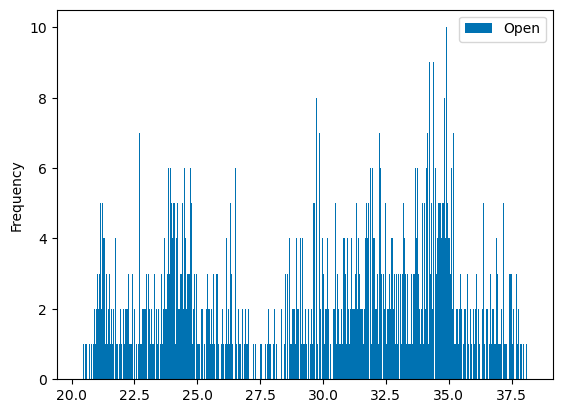

In [30]:
df.plot(kind='hist', bins=500) # Opening prices are not normal

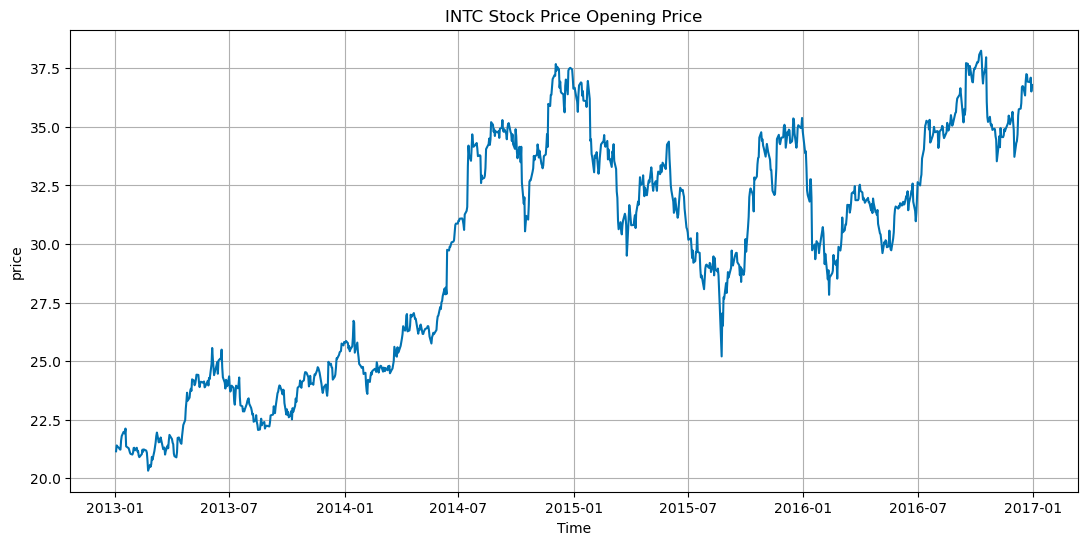

In [31]:
# Plot data
plt.figure(figsize=(13,6))
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('price')
plt.title('INTC Stock Price Opening Price')
plt.grid()
plt.show()

## Train Test Split

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

In [50]:
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

In [51]:
# Expanding Window 交叉验证
errors = []
predictions_list = []
actuals_list = []


In [52]:
from pmdarima import auto_arima

# Expanding Window 交叉验证
for train_index, test_index in tscv.split(df):
    train, test = df.iloc[train_index], df.iloc[test_index]
    
    
    # 使用 auto_arima 根据训练集自动调整 ARIMA 参数
    model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
    
    # 预测测试集的长度
    predictions = model.predict(n_periods=len(test))
    predictions_list.append(predictions)
    
    # Calculate MAPE
    mape_error = mean_absolute_percentage_error(test, predictions)
    errors.append(mape_error)
    

# Output the error metrics for each fold
print(f'MAPE for each fold: {mape_errors}')
print(f'Mean MAPE: {np.mean(mape_errors)}')


MAPE for each fold: [0.03966600423787419, 0.03966600423787419, 0.06201655776175737, 0.06843294333225615, 0.06728059415895547, 0.050763415007152625, 0.043370366480656654, 0.07478791302854826, 0.10707288925767437, 0.04608588955649743, 0.030318041903415492]
Mean MAPE: 0.05722369263296929


In [48]:
train = df['Open'][:'2016-01-01']
test = df['Open']['2016-01-01':]
model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
predictions = model.predict(n_periods=len(test))

In [49]:
predictions

756     34.880166
757     34.820621
758     34.879551
759     34.821229
760     34.878949
          ...    
1003    34.847933
1004    34.852521
1005    34.847980
1006    34.852475
1007    34.848026
Length: 252, dtype: float64

In [37]:
tss = TimeSeriesSplit(n_splits = 10)
df = df.sort_index()

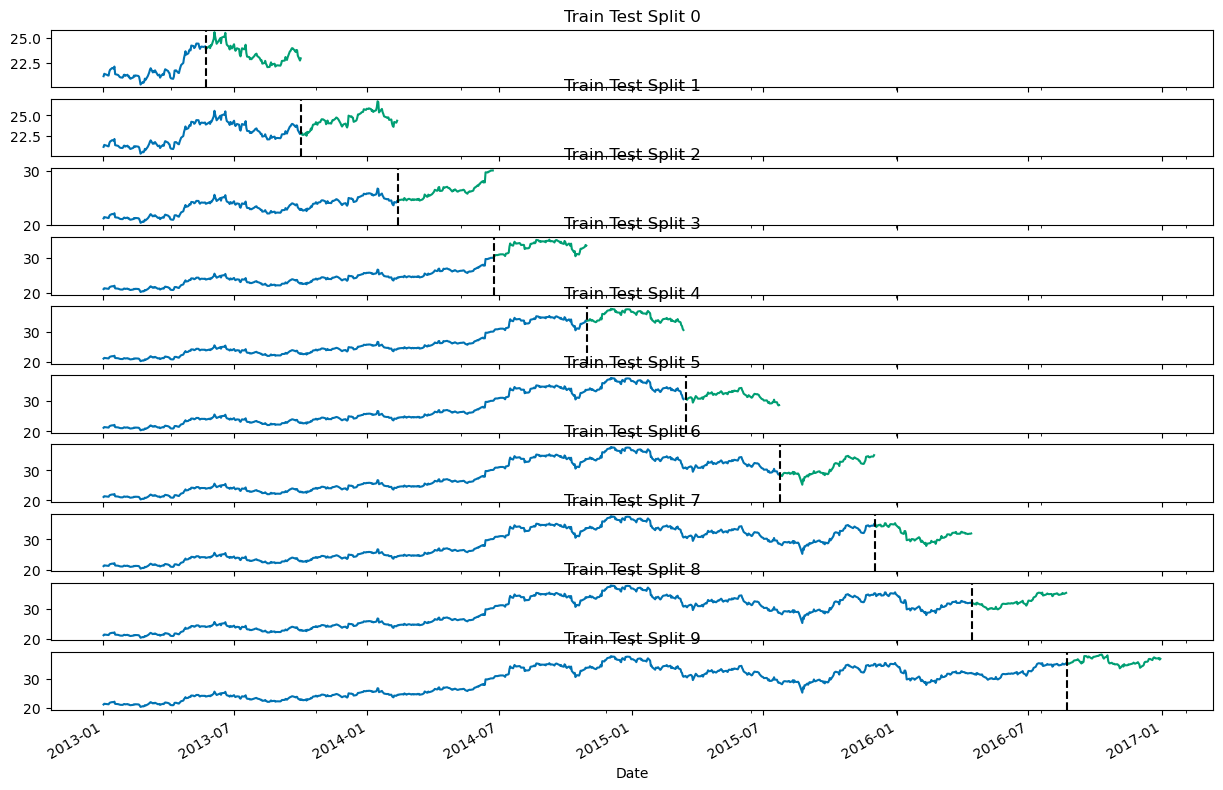

In [38]:
fig, axs = plt.subplots(10, 1, figsize=(15,10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Open'].plot(ax = axs[fold],
                          label='Training Set',
                          title = f'Train Test Split {fold}')
    test['Open'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## 2. Assessing stationarity

There are useful ways to examine the stationarity of a given time series:
- **Visualisation:**
    - We can assess the stationarity of a time series by assessing its **sample ACF** plot. In general, it can be shown that for nonseasonal time series:
        - If the sample ACF of a nonseasonal time series **cuts off or dies down reasonably quickly**, then the time series should be considered it stationary.
        - If the sample ACF of a nonseasonal time series **dies down extremely slowly or not at all**, then the time series should be considered it nonstationary.
    - If the time series exhibit clear trend or seasonality, it is non-stationary (why?).
- **Hypothesis testing:** For example, we can perform the Dickey-Fuller test discussion in the optional section to test the null hypothesis saying that the given time series is stationary.

For example, let's generate the sample ACF plot of the sales data using a built-in function of `statsmodels.api`

In [39]:
import statsmodels as sm
import statsmodels.api as smt

In [40]:
# Plot the sample ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(price, lags=30, alpha = 0.05)
plt.show()
# ACF dies down extremely, Non-stationary

NameError: name 'price' is not defined

In [ ]:
# We calculate difference series, Y[1]-Y[0], Y[2]-Y[1],...
price_diff = pd.Series.diff(price)
price_diff

In [ ]:
# Discard the nan value
price_diff = price_diff.dropna()
price_diff

In [ ]:
# Plot the differenced data
plt.figure(figsize=(13,6))
plt.plot(price_diff)
plt.xlabel('Time')
plt.title('price differencing')
plt.grid()
plt.show()

## Plot ACF and PACF using diff data

In [ ]:
# Sample ACF
smt.graphics.tsa.plot_acf(price_diff, lags=30, alpha = 0.05)
plt.show()

# Sample PACF
smt.graphics.tsa.plot_pacf(price_diff, lags=30, alpha = 0.05)
plt.show()

In [63]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Create an ARIMA (0,1,0) model
model = ARIMA(price, order=(0, 1, 0))
model_fit = model.fit()

# Get the summary of the fitted model
print(model_fit.summary())

## Train Test Split

- Important to prevent our model from horribly overfitting

In [65]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

In [ ]:
train

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

train['Open'].plot(ax=ax, label='Train', title='Train/Test Split')
test['Open'].plot(ax=ax, label='Test')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [ ]:
# visualising one week
df['Open'].loc[(df.index >'01-01-2015') & (df.index < '01-11-2015')] \
    .plot(figsize=(15,5), title='10 Days of Data') # note & denotes element-wise logical, whereas 'and' will ask python to typecast into bool

### Using Time Series Cross Validation

In [69]:
from sklearn.model_selection import TimeSeriesSplit

In [70]:
tss = TimeSeriesSplit(n_splits = 5)
df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15,10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Open'].plot(ax = axs[fold],
                          label='Training Set',
                          title = f'Train Test Split {fold}')
    test['Open'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Feature Creation

In [72]:
def create_features(df):
    """
    Create time series features given df with datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [73]:
df = create_features(df)

### Lag Features

#### What was the target x days in the past

In [74]:
def add_lags(df):
    target_map = df['Open'].to_dict()
    pct_map = df['Pct Change'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['Pct_lag_1'] = (df.index - pd.Timedelta('1 days')).map(pct_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
df.tail(5)

### Visalising Feature / Target Relationship

In [ ]:
df.columns

In [ ]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['Open']].sort_values(by=['Open'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with Open Price, descending');
plt.tight_layout()

We can see that the most strongly correlated variable is high, low, close (which we shouldn't know), but also the lag features and the year

## Model Creation

In [ ]:
tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['year', 'lag1','lag2', 'month', 'dayofweek', 'quarter', 'Volume']
    TARGET = 'Open'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mse(y_test, y_pred))
    scores.append(score)

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

### Feature Importances

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [29]:
# predict on test data
test['prediction'] = reg.predict(X_test)

In [30]:
# merging with the df and the test dataset
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
df.loc[(df.index >'11-03-2016')][['Open', 'prediction']] \
    .plot(figsize=(15,5), ms=1, lw=1, title='Predictions vs Truth');